In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
pd.set_option("display.max_columns", 500)

In [18]:
train = pd.read_csv("train.csv")
validate = pd.read_csv("validate.csv")
test = pd.read_csv("test.csv")

train.shape

(7243, 78)

In [19]:
train_x = train.drop(['price_log'], axis = 1)
train_y = train[['price_log']]

validate_x = validate.drop(['price_log'], axis = 1)
validate_y = validate[['price_log']]

test_x = test.drop(['price_log'], axis = 1)
test_y = test[['price_log']]

# Lasso

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.98000468328803, tolerance: 0.34972971273649156
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.33792517336383, tolerance: 0.34972971273649156
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9357963138629657, tolerance: 0.34972971273649156
  positive)


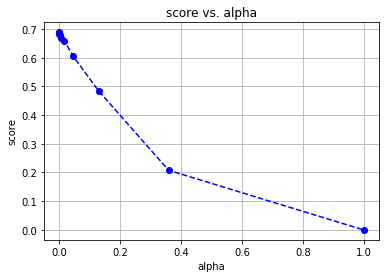

The optimaized alpha and score of Lasso linear is:  0.0001 0.6887923974241297


In [20]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score


alphas = np.logspace (-4, 0, num=10)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(train_x, train_y)
    scores[i] = lasso.score(validate_x, validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [21]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(train_x, train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.98000468328803, tolerance: 0.34972971273649156
  positive)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Feature Importance & Feature Selection

In [22]:
lasso_f_coeffs = pd.DataFrame({'name': train_x.columns.tolist(),
                               'coef': lasso_f.coef_,
                               'coef_abs': np.abs(lasso_f.coef_)}) 

,name,coef,coef_abs
35,distance_to_national_monument,0.904356,0.904356
40,distance_to_sunsetcliff,-0.769912,0.769912
30,Shared room,-0.536330,0.536330
41,distance_to_convention_center,-0.413947,0.413947
27,Entire home/apt,0.398830,0.398830
33,distance_to_balboa_park,0.331449,0.331449
39,distance_to_torreybeach,0.256972,0.256972
4,accommodates,0.211389,0.211389
76,distance_min,-0.186789,0.186789
5,bedrooms,0.141792,0.141792


In [23]:
np.sum(lasso_f.coef_ == 0)

4

In [24]:
lasso_f_coeffs.loc[lasso_f_coeffs['coef'] == 0,:]

,name,coef,coef_abs
2,host_has_profile_pic,0.0,0.0
10,is_business_travel_ready,0.0,0.0
29,Private room,-0.0,0.0
34,distance_to_san_diego_zoo,0.0,0.0


# Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

train_x = train_x.append(validate_x, ignore_index = True)
train_y = train_y.append(validate_y, ignore_index = True)


param_grid = {
                 'n_estimators': [260, 280], 
                 'max_depth': [50, 52]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(train_x, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    7.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=3, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [50, 52], 'n_estimato

In [26]:
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.868129,0.099374,0.125725,0.003432,50,260,"{'max_depth': 50, 'n_estimators': 260}",0.708305,0.736434,0.713950,0.703361,0.73668,0.719747,0.014129,1
2,5.748623,0.035158,0.123030,0.003339,52,260,"{'max_depth': 52, 'n_estimators': 260}",0.708305,0.736434,0.713950,0.703361,0.73668,0.719747,0.014129,1
1,6.319593,0.077792,0.132251,0.002315,50,280,"{'max_depth': 50, 'n_estimators': 280}",0.708288,0.736626,0.713595,0.703326,0.73686,0.719740,0.014259,3
3,6.331706,0.110826,0.136238,0.001809,52,280,"{'max_depth': 52, 'n_estimators': 280}",0.708288,0.736626,0.713595,0.703326,0.73686,0.719740,0.014259,3


In [27]:
grid_rf.best_params_

{'max_depth': 50, 'n_estimators': 260}

In [28]:
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 80, n_estimators=120)
rf.fit(train_x, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

## RF 2: removing the 4 redundant features

In [29]:
train_x2 = train_x.drop(['host_has_profile_pic','is_business_travel_ready','distance_to_san_diego_zoo'], axis = 1)
test_x2 = test_x.drop(['host_has_profile_pic','is_business_travel_ready','distance_to_san_diego_zoo'], axis = 1)



param_grid = {
                 'n_estimators': [260, 280], 
                 'max_depth': [50, 52]
             }

rf2 = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
grid_rf2 = GridSearchCV(rf2, param_grid, cv=5)
grid_rf2.fit(train_x2, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.2s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    7.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=3, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [50, 52], 'n_estimato

In [ ]:
pd.DataFrame(grid_rf2.cv_results_).sort_values('mean_test_score', ascending = False)

In [30]:
grid_rf2.best_params_

{'max_depth': 50, 'n_estimators': 280}

In [31]:
rf2 = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 80, n_estimators=120)
rf2.fit(train_x2, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

In [35]:
train_x3 = train_x.drop(['host_has_profile_pic','is_business_travel_ready','distance_to_san_diego_zoo',
                         'Private room'], axis = 1)
test_x3 = test_x.drop(['host_has_profile_pic','is_business_travel_ready','distance_to_san_diego_zoo',
                         'Private room'], axis = 1)



param_grid = {
                 'n_estimators': [260, 280], 
                 'max_depth': [50, 52]
             }

rf3 = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
grid_rf3 = GridSearchCV(rf3, param_grid, cv=5)
grid_rf3.fit(train_x3, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.2s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.2s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.2s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
b

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.1s finished
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
b

[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    7.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=3, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [50, 52], 'n_estimato

In [36]:
pd.DataFrame(grid_rf3.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.038250,0.092780,0.143899,0.005511,50,260,"{'max_depth': 50, 'n_estimators': 260}",0.706158,0.731824,0.712420,0.702770,0.734826,0.717600,0.013242,1
2,5.709084,0.027872,0.123880,0.005501,52,260,"{'max_depth': 52, 'n_estimators': 260}",0.706158,0.731824,0.712420,0.702770,0.734826,0.717600,0.013242,1
1,6.306884,0.086034,0.143976,0.012228,50,280,"{'max_depth': 50, 'n_estimators': 280}",0.706435,0.732229,0.711993,0.702174,0.734935,0.717554,0.013480,3
3,6.325112,0.211038,0.138471,0.011360,52,280,"{'max_depth': 52, 'n_estimators': 280}",0.706435,0.732229,0.711993,0.702174,0.734935,0.717554,0.013480,3


In [37]:
grid_rf3.best_params_

{'max_depth': 50, 'n_estimators': 260}

In [38]:
rf3 = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 80, n_estimators=120)
rf3.fit(train_x3, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

# Model Evaluation

## Lasso

In [32]:
lasso_f_score = lasso_f.score(test_x, test_y)
pred_y = lasso_f.predict(test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(test_y, pred_y))

print('lasso_f score: ', lasso_f_score)
print('Mean square error of lasso_f: ', MSE_lasso_f)
print('Root mean squared error of lasso_f:', RMSE_lasso_f)
# print ('Coefficients of lasso_f: ', lasso_f.coef_)

lasso_f score:  0.6702427620075238
Mean square error of lasso_f:  0.15153998654348672
Root mean squared error of lasso_f: 0.38928137194513524


## Random Forest

In [33]:
rf_score = rf.score(test_x, test_y)

pred_y = rf.predict(test_x)
MSE_rf = mean_squared_error(test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(test_y, pred_y))

# The mean squared error and root mean square error
print('rf score: ', rf_score) 
print('Mean square error of rf: ', MSE_rf) 
print('Root mean squared error of rf:', RMSE_rf) 
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.7351525615002611
Mean square error of rf:  0.12171067877285861
Root mean squared error of rf: 0.34887057596314797


In [34]:
rf_score2 = rf2.score(test_x2, test_y)

pred_y2 = rf2.predict(test_x2)
MSE_rf2 = mean_squared_error(test_y, pred_y2)
RMSE_rf2 = sqrt(mean_squared_error(test_y, pred_y2))

# The mean squared error and root mean square error
print('rf score: ', rf_score2) 
print('Mean square error of rf: ', MSE_rf2) 
print('Root mean squared error of rf:', RMSE_rf2) 
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.7354294069972148
Mean square error of rf:  0.12158345438458319
Root mean squared error of rf: 0.3486881907730504


In [39]:
rf_score3 = rf3.score(test_x3, test_y)

pred_y3 = rf3.predict(test_x3)
MSE_rf3 = mean_squared_error(test_y, pred_y3)
RMSE_rf3 = sqrt(mean_squared_error(test_y, pred_y3))

# The mean squared error and root mean square error
print('rf score: ', rf_score3) 
print('Mean square error of rf: ', MSE_rf3) 
print('Root mean squared error of rf:', RMSE_rf3) 
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.7321499389556847
Mean square error of rf:  0.12309053439868314
Root mean squared error of rf: 0.350842606304712


# Feature Importance

## From Lasso

In [43]:
lasso_f_coeffs.sort_values(['coef_abs'], ascending = False).head(40)

,name,coef,coef_abs
35,distance_to_national_monument,0.904356,0.904356
40,distance_to_sunsetcliff,-0.769912,0.769912
30,Shared room,-0.536330,0.536330
41,distance_to_convention_center,-0.413947,0.413947
27,Entire home/apt,0.398830,0.398830
33,distance_to_balboa_park,0.331449,0.331449
39,distance_to_torreybeach,0.256972,0.256972
4,accommodates,0.211389,0.211389
76,distance_min,-0.186789,0.186789
5,bedrooms,0.141792,0.141792


## From RF

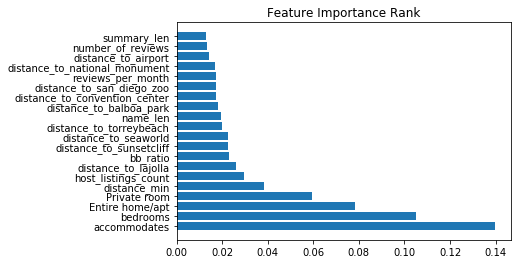

In [41]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = test_x.columns.get_values()

importance_df = pd.DataFrame({'name': feature_name, 'importance': importances})
importance_df['YN'] = [x[:12] == 'PULocationID' for x in importance_df.name.values]
importance_df.append({'importance':sum(importance_df.loc[importance_df.YN].importance), 
                      'name':'PULocationID',
                      'YN': False}, ignore_index=True)
importance_df = importance_df.loc[importance_df.YN == False].sort_values(['importance'], ascending = False).iloc[0:20,]

plt.figure(1)
plt.barh(np.arange(importance_df.shape[0]), importance_df.importance)
plt.yticks(np.arange(importance_df.shape[0]), importance_df.name)
plt.title('Feature Importance Rank')
plt.show()

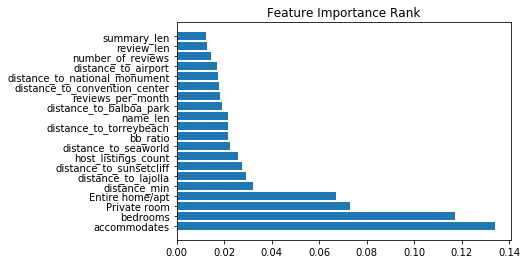

In [45]:
importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = test_x2.columns.get_values()

importance_df = pd.DataFrame({'name': feature_name, 'importance': importances})
importance_df['YN'] = [x[:12] == 'PULocationID' for x in importance_df.name.values]
importance_df.append({'importance':sum(importance_df.loc[importance_df.YN].importance), 
                      'name':'PULocationID',
                      'YN': False}, ignore_index=True)
importance_df1 = importance_df.loc[importance_df.YN == False].sort_values(['importance'], ascending = False).iloc[0:20,]

plt.figure(1)
plt.barh(np.arange(importance_df1.shape[0]), importance_df1.importance)
plt.yticks(np.arange(importance_df1.shape[0]), importance_df1.name)
plt.title('Feature Importance Rank')
plt.show()

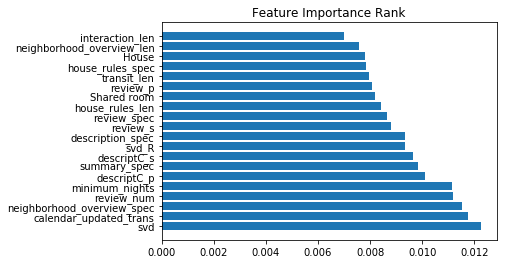

In [46]:
importance_df2 = importance_df.loc[importance_df.YN == False].sort_values(['importance'], ascending = False).iloc[20:40,]

plt.figure(1)
plt.barh(np.arange(importance_df2.shape[0]), importance_df2.importance)
plt.yticks(np.arange(importance_df2.shape[0]), importance_df2.name)
plt.title('Feature Importance Rank')
plt.show()